In [1]:
import numpy as np
from astropy import units as u
from astropy import coordinates as coords
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from spectres import spectres
from astroquery.ipac.ned import Ned
from astroquery.ipac.irsa.irsa_dust import IrsaDust
from scipy.optimize import curve_fit
import scipy.optimize as opt
import pandas as pd

In [2]:
def get_obs(igalaxy, icluster):
    file = galaxy[igalaxy]+'_'+cluster[icluster]+'.csv'
    x = np.genfromtxt(file, usecols=0)
    y = np.genfromtxt(file, usecols=1) # Observation corrected for Milky Waw reddening and flux in units of 10^-15 erg/s/cm2/A   
    return x, y

In [3]:
def get_error(x,y):
    xwin = np.array([1147, 1150, 1221, 1224, 1266, 1267, 1356, 1360, 1420, 1422, 1475, 1477, 1507, 1510, 1565, 1567, 1615, 1618, 1677, 1680])
    dev_std=[]
    for i in range(0,20,2):
        arr = y[np.where((x>=xwin[i]) & (x<=xwin[i+1]))]
        std_value = np.std(arr)
        dev_std.append(std_value)
    dev_std_arr = np.array(dev_std)
    return np.average(dev_std_arr)


In [4]:
def get_mod(it, iZ):
    ages = [.1e6, .2e6, .3e6, .4e6, .5e6, .6e6, .7e6, .8e6, .9e6, 1e6, # Model ages of interest in Myr
            1.1e6, 1.2e6, 1.3e6, 1.4e6, 1.5e6, 1.6e6, 1.7e6, 1.8e6, 1.9e6, 2e6,
            2.1e6, 2.2e6, 2.3e6, 2.4e6, 2.5e6, 2.6e6, 2.7e6, 2.8e6, 2.9e6, 3e6,
            3.1e6, 3.2e6, 3.3e6, 3.4e6, 3.5e6, 3.6e6, 3.7e6, 3.8e6, 3.9e6, 4e6,
            4.1e6, 4.2e6, 4.3e6, 4.4e6, 4.5e6, 4.6e6, 4.7e6, 4.8e6, 4.9e6, 5e6,
            5.1e6, 5.2e6, 5.3e6, 5.4e6, 5.5e6, 5.6e6, 5.7e6, 5.8e6, 5.9e6, 6e6,
            6.1e6, 6.2e6, 6.3e6, 6.4e6, 6.5e6, 6.6e6, 6.7e6, 6.8e6, 6.9e6, 7e6,
            7.1e6, 7.2e6, 7.3e6, 7.4e6, 7.5e6, 7.6e6, 7.7e6, 7.8e6, 7.9e6, 8e6,
            8.1e6, 8.2e6, 8.3e6, 8.4e6, 8.5e6, 8.6e6, 8.7e6, 8.8e6, 8.9e6, 9e6,
            9.1e6, 9.2e6, 9.3e6, 9.4e6, 9.5e6, 9.6e6, 9.7e6, 9.8e6, 9.9e6,]
    if iZ==0:
        path='v00_z014.csv'
    if iZ==1:
        path='v00_z040.csv'
    data=np.loadtxt(path,delimiter=",")
    time, wave, logL, norm = np.transpose(data) # Model obtained with a starbust 99 simulation
    good_indices = np.nonzero((time == ages[it]) & (wave >= 1150.) & (wave <=1700.))# Select good portion of spectrum
    x99=wave[good_indices]
    y99=norm[good_indices]
    return x99, y99

In [5]:
def zcorr(x, target):
    result_table = Ned.query_object(target)
    z = result_table['Redshift'][0]
    xrest = x / (1 + z) #Redshift correction of the galaxy moving radially with respect to the observer
    return xrest, z

In [6]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [7]:
def find_plt_lim(x, y):
    good_indices = np.nonzero(x > 1320.)
    ymin = min(y[good_indices])
    good_indices = np.nonzero(x < 1200.)
    ymax = max(y[good_indices])
    return ymin, ymax 

In [8]:
def chisqfunc(obs, err, mod):
    chisq = np.sum(((obs - mod)/err)**2)
    return chisq

In [9]:
galaxy = ['NGC-1512','NGC-1566','M-51'] # For building name of file with observation
cluster = ['YSC1','YSC2'] # For building name of file with observation
galaxys = ['NGC 1512', 'NGC 1566', 'M51'] # For looking up galaxy in virtual observatory
age_str = [.1e6, .2e6, .3e6, .4e6, .5e6, .6e6, .7e6, .8e6, .9e6, 1e6, # Model ages of interest in Myr
                1.1e6, 1.2e6, 1.3e6, 1.4e6, 1.5e6, 1.6e6, 1.7e6, 1.8e6, 1.9e6, 2e6,
                2.1e6, 2.2e6, 2.3e6, 2.4e6, 2.5e6, 2.6e6, 2.7e6, 2.8e6, 2.9e6, 3e6,
                3.1e6, 3.2e6, 3.3e6, 3.4e6, 3.5e6, 3.6e6, 3.7e6, 3.8e6, 3.9e6, 4e6,
                4.1e6, 4.2e6, 4.3e6, 4.4e6, 4.5e6, 4.6e6, 4.7e6, 4.8e6, 4.9e6, 5e6,
                5.1e6, 5.2e6, 5.3e6, 5.4e6, 5.5e6, 5.6e6, 5.7e6, 5.8e6, 5.9e6, 6e6,
                6.1e6, 6.2e6, 6.3e6, 6.4e6, 6.5e6, 6.6e6, 6.7e6, 6.8e6, 6.9e6, 7e6,
                7.1e6, 7.2e6, 7.3e6, 7.4e6, 7.5e6, 7.6e6, 7.7e6, 7.8e6, 7.9e6, 8e6,
                8.1e6, 8.2e6, 8.3e6, 8.4e6, 8.5e6, 8.6e6, 8.7e6, 8.8e6, 8.9e6, 9e6,
                9.1e6, 9.2e6, 9.3e6, 9.4e6, 9.5e6, 9.6e6, 9.7e6, 9.8e6, 9.9e6,]

models=['v00_z014', 'v00_z040'] # Metallicities with which to work

In [10]:
xlo=1263.
xhi=1645.
dx=2.

In [11]:
galaxy_df=[]
cluster_df=[]
age_df=[]
met_df=[]
chisqlist=[]

for igalaxy in range(3):
    for icluster in range(2):
        for iage in range(99):
            for imetallicity in range(2):
                x, y= get_obs(igalaxy, icluster)     # Get observation
                x99, y99 = get_mod(iage, imetallicity)     # Get common array from model
                y99_resampled = spectres(x, x99, y99, fill=0.)
                error = get_error(x,y)
                dy = np.array(len(x)*[error])
                fitReg1=np.squeeze(np.nonzero((x>=1233.) & (x<=1238.)))
                fitReg2=np.squeeze(np.nonzero((x>=1243.5) & (x<=1246.5)))
                fitReg3=np.squeeze(np.nonzero((x>=1404.) & (x<=1409.)))
                fitReg4=np.squeeze(np.nonzero((x>=1535.) & (x<=1540.)))
                fitReg5=np.squeeze(np.nonzero((x>=1552.) & (x<=1557.)))
                fit = np.concatenate((fitReg1,fitReg2,fitReg3,fitReg4,fitReg5))
                chisq = chisqfunc(y[fit],dy[fit],y99_resampled[fit])
                galaxy_df.append(galaxy[igalaxy])
                cluster_df.append(cluster[icluster])
                age_df.append(format(age_str[iage],'.1E'))
                met_df.append(models[imetallicity])
                chisqlist.append(chisq)

df = pd.DataFrame(list(zip(galaxy_df,cluster_df,age_df,met_df,chisqlist)), columns = ['Galaxy','Cluster','Age','Metallicity','Chisq'])


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

In [12]:
df_backup = df

In [13]:
df_sorted = df.sort_values(['Galaxy', 'Cluster','Metallicity'], ascending= False)
df_sorted1 = df_sorted.sort_values(['Chisq'], ascending= False)

In [14]:
df_result_sorted = []
df_results = []

for igalaxy in range(3):
  for icluster in range(2):
    galaxys = galaxy[igalaxy]
    clusters = cluster[icluster]
    df_result_sorted = df_sorted1[(df_sorted1.Galaxy == galaxys) & (df_sorted1.Cluster == clusters)][-1:]
    df_results.append(df_result_sorted.values.squeeze())

In [16]:
lines=[1238.82,1242.80,1393.76,1402.77,1501.76,1548.19,1550.77]

In [17]:
galaxy = ['NGC-1512','NGC-1566','M-51'] # For building name of file with observation
cluster = ['YSC1','YSC2'] # For building name of file with observation
galaxys = ['NGC 1512', 'NGC 1566', 'M51'] # For looking up galaxy in virtual observatory
age_str = [.1e6, .2e6, .3e6, .4e6, .5e6, .6e6, .7e6, .8e6, .9e6, 1e6, # Model ages of interest in Myr
                1.1e6, 1.2e6, 1.3e6, 1.4e6, 1.5e6, 1.6e6, 1.7e6, 1.8e6, 1.9e6, 2e6,
                2.1e6, 2.2e6, 2.3e6, 2.4e6, 2.5e6, 2.6e6, 2.7e6, 2.8e6, 2.9e6, 3e6,
                3.1e6, 3.2e6, 3.3e6, 3.4e6, 3.5e6, 3.6e6, 3.7e6, 3.8e6, 3.9e6, 4e6,
                4.1e6, 4.2e6, 4.3e6, 4.4e6, 4.5e6, 4.6e6, 4.7e6, 4.8e6, 4.9e6, 5e6,
                5.1e6, 5.2e6, 5.3e6, 5.4e6, 5.5e6, 5.6e6, 5.7e6, 5.8e6, 5.9e6, 6e6,
                6.1e6, 6.2e6, 6.3e6, 6.4e6, 6.5e6, 6.6e6, 6.7e6, 6.8e6, 6.9e6, 7e6,
                7.1e6, 7.2e6, 7.3e6, 7.4e6, 7.5e6, 7.6e6, 7.7e6, 7.8e6, 7.9e6, 8e6,
                8.1e6, 8.2e6, 8.3e6, 8.4e6, 8.5e6, 8.6e6, 8.7e6, 8.8e6, 8.9e6, 9e6,
                9.1e6, 9.2e6, 9.3e6, 9.4e6, 9.5e6, 9.6e6, 9.7e6, 9.8e6, 9.9e6,]

models=['v00_z014', 'v00_z040'] # Metallicities with which to work
print(galaxys[0])

NGC 1512


In [15]:
df_results

[array(['NGC-1512', 'YSC1', '3.4E+06', 'v00_z014', 396.4955523568096],
       dtype=object),
 array(['NGC-1512', 'YSC2', '3.4E+06', 'v00_z040', 1175.2924771908617],
       dtype=object),
 array(['NGC-1566', 'YSC1', '4.6E+06', 'v00_z014', 241.34420521204473],
       dtype=object),
 array(['NGC-1566', 'YSC2', '3.5E+06', 'v00_z014', 245.77111367068707],
       dtype=object),
 array(['M-51', 'YSC1', '3.3E+06', 'v00_z014', 254.9692702425989],
       dtype=object),
 array(['M-51', 'YSC2', '4.6E+06', 'v00_z014', 269.50756969544733],
       dtype=object)]


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 

v00_z014
4600000.0
269.50756969544733


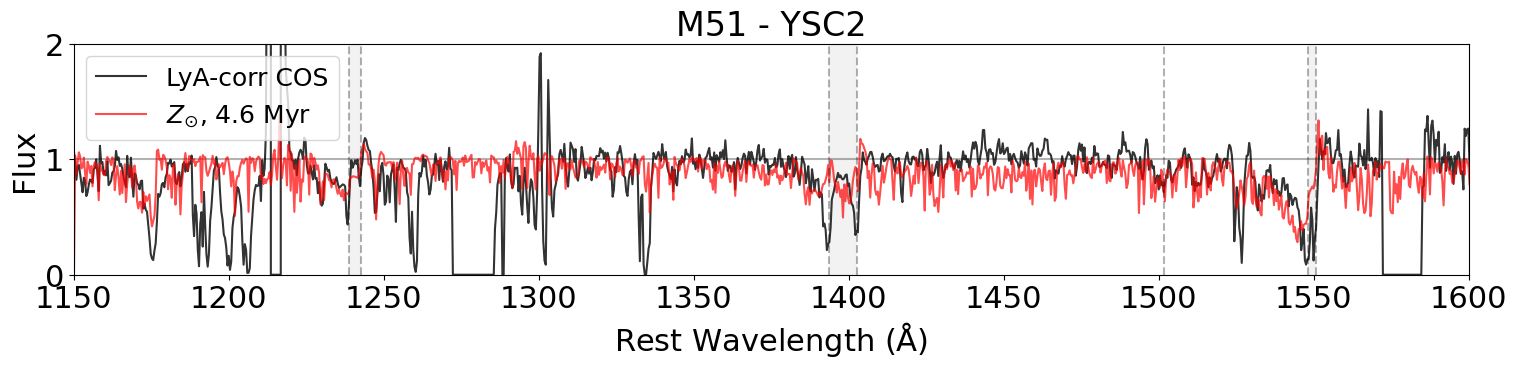

In [80]:
igalaxy = 2
icluster = 1
iage = 45
imetallicity = 0

x, y= get_obs(igalaxy, icluster)     # Get observation
x99, y99 = get_mod(iage, imetallicity)     # Get common array from model
y99_resampled = spectres(x, x99, y99, fill=0.)
error = get_error(x,y)
dy = np.array(len(x)*[error])
fitReg1=np.squeeze(np.nonzero((x>=1233.) & (x<=1238.)))
fitReg2=np.squeeze(np.nonzero((x>=1243.5) & (x<=1246.5)))
fitReg3=np.squeeze(np.nonzero((x>=1404.) & (x<=1409.)))
fitReg4=np.squeeze(np.nonzero((x>=1535.) & (x<=1540.)))
fitReg5=np.squeeze(np.nonzero((x>=1552.) & (x<=1557.)))
fit = np.concatenate((fitReg1,fitReg2,fitReg3,fitReg4,fitReg5))
chisq = chisqfunc(y[fit],dy[fit],y99_resampled[fit])
# ------
print(models[imetallicity])
print(age_str[iage])
print(chisq)
# ------
plt.figure(figsize=(18,3))
plt.xlim(1150,1600)     # Set limits of horizontal axis
plt.ylim(0,2)     # Set limits of vertical axis 
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.xlabel(r'Rest Wavelength ($\rm{\AA}$)', fontsize=22)    # Set label of horizontal axis
plt.ylabel('Flux', fontsize=22) # Set label of vertical axis
plt.plot(x, y, color='black', alpha=0.8, label='LyA-corr COS') # ---------- OBSERVACION ----------
plt.axvline(x=1238.82 ,color="black",alpha=0.3,zorder=10,linestyle = 'dashed')
plt.axvline(x=1242.80 ,color="black",alpha=0.3,zorder=10,linestyle = 'dashed')
plt.axvspan(1238.82, 1242.80, facecolor ='black', alpha = 0.05)
plt.axvline(x=1393.76 ,color="black",alpha=0.3,zorder=10,linestyle = 'dashed')
plt.axvline(x=1402.77 ,color="black",alpha=0.3,zorder=10,linestyle = 'dashed')
plt.axvspan(1393.76, 1402.77, facecolor ='black', alpha = 0.05)
plt.axvline(x=1501.76 ,color="black",alpha=0.3,zorder=10,linestyle = 'dashed')
plt.axvline(x=1548.19 ,color="black",alpha=0.3,zorder=10,linestyle = 'dashed')
plt.axvline(x=1550.77 ,color="black",alpha=0.3,zorder=10,linestyle = 'dashed')
plt.axvspan(1548.19, 1550.77, facecolor ='black', alpha = 0.05)
plt.axhline(y = 1.0, color = 'black', alpha=0.3, linestyle = '-')
plt.plot(x, y99_resampled, color='red', alpha=0.7, label='$Z_{\odot}$, 4.6 Myr')
plt.title(galaxys[igalaxy]+' - '+cluster[icluster], fontsize=24)    # Set plot title
plt.legend(loc="upper left", fontsize=18)


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 

v00_z014
4600000.0
269.50756969544733


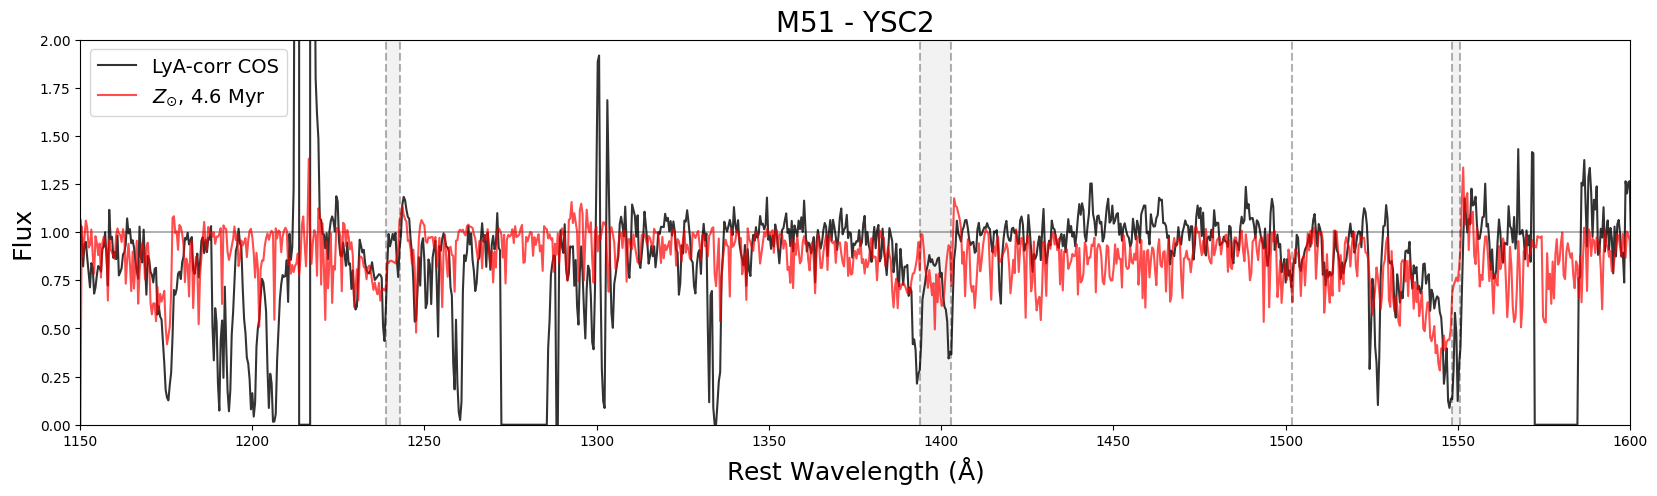

In [58]:
igalaxy = 2
icluster = 1
iage = 45
imetallicity = 0

x, y= get_obs(igalaxy, icluster)     # Get observation
x99, y99 = get_mod(iage, imetallicity)     # Get common array from model
y99_resampled = spectres(x, x99, y99, fill=0.)
error = get_error(x,y)
dy = np.array(len(x)*[error])
fitReg1=np.squeeze(np.nonzero((x>=1233.) & (x<=1238.)))
fitReg2=np.squeeze(np.nonzero((x>=1243.5) & (x<=1246.5)))
fitReg3=np.squeeze(np.nonzero((x>=1404.) & (x<=1409.)))
fitReg4=np.squeeze(np.nonzero((x>=1535.) & (x<=1540.)))
fitReg5=np.squeeze(np.nonzero((x>=1552.) & (x<=1557.)))
fit = np.concatenate((fitReg1,fitReg2,fitReg3,fitReg4,fitReg5))
chisq = chisqfunc(y[fit],dy[fit],y99_resampled[fit])
# ------
print(models[imetallicity])
print(age_str[iage])
print(chisq)
# ------
plt.figure(figsize=(20,5))
plt.xlim(1150,1600)     # Set limits of horizontal axis
plt.ylim(0,2)     # Set limits of vertical axis 
plt.xlabel(r'Rest Wavelength ($\rm{\AA}$)', fontsize=18)    # Set label of horizontal axis
plt.ylabel('Flux', fontsize=18) # Set label of vertical axis
plt.plot(x, y, color='black', alpha=0.8, label='LyA-corr COS') # ---------- OBSERVACION ----------
plt.axvline(x=1238.82 ,color="black",alpha=0.3,zorder=10,linestyle = 'dashed')
plt.axvline(x=1242.80 ,color="black",alpha=0.3,zorder=10,linestyle = 'dashed')
plt.axvspan(1238.82, 1242.80, facecolor ='black', alpha = 0.05)
plt.axvline(x=1393.76 ,color="black",alpha=0.3,zorder=10,linestyle = 'dashed')
plt.axvline(x=1402.77 ,color="black",alpha=0.3,zorder=10,linestyle = 'dashed')
plt.axvspan(1393.76, 1402.77, facecolor ='black', alpha = 0.05)
plt.axvline(x=1501.76 ,color="black",alpha=0.3,zorder=10,linestyle = 'dashed')
plt.axvline(x=1548.19 ,color="black",alpha=0.3,zorder=10,linestyle = 'dashed')
plt.axvline(x=1550.77 ,color="black",alpha=0.3,zorder=10,linestyle = 'dashed')
plt.axvspan(1548.19, 1550.77, facecolor ='black', alpha = 0.05)
plt.axhline(y = 1.0, color = 'black', alpha=0.3, linestyle = '-')
plt.plot(x, y99_resampled, color='red', alpha=0.7, label='$Z_{\odot}$, 3.4 Myr')
plt.title(galaxys[igalaxy]+' - '+cluster[icluster], fontsize=20)    # Set plot title
plt.legend(fontsize=14)